<h1 text-align="center}>Linear Regression Project: Canada Rent</h1>

<h1 style="text-align:center;">Canada Rent Price Predciton - Linear Regression Project</h1>
<p style="text-align:right"><b>Project Co-created by: Flora Wong, Naudeen Stewart, Kun Bi</b></p>

## Step 1: Install + Import Necessary Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid",palette="tab20")

## Step 2: EDA - Data Cleanning + Preprossing + Visualisation

In [6]:
df=pd.read_csv("canada_rent.csv")
df.head(1)

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True


In [7]:
def date_reclass(x):
    if x=="Immediate":
        return "Immediate"
    elif x=="Negotiable":
        return "Negotiable"
    else:
        return "not right away"

#regroup some columns
rent=df.dropna().drop(columns=["rentfaster_id","link","longitude","latitude","city","province"]).assign(
        city_province=df.city+", "+df.province,
        lease_term=df.lease_term.map({"Long Term":"Long Term","Negotiable":"Negotiable","Short Term":"Short Term","12 months":"Less than a Year","months":"Less than a Year","6 months":"Less than a Year",np.nan:"missing"}),
        #beds=df.beds.str.extract("(\d+)",expand=False).astype("float"),
        baths=df.baths.replace({"none":"0"}),
        sq_feet=pd.to_numeric(df.sq_feet.str.extract("(\d+)",expand=False)),
        availability_date=df.availability_date.apply(date_reclass)
        
)
rent.head(2)

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_4084/3893069411.py:15: SyntaxWarning: invalid escape sequence '\d'
  sq_feet=pd.to_numeric(df.sq_feet.str.extract("(\d+)",expand=False)),


,address,lease_term,type,price,beds,baths,sq_feet,furnishing,availability_date,smoking,cats,dogs,city_province
0,69 Gateway Dr NE,Long Term,Townhouse,2495.0,2 Beds,2.5,1403.0,Unfurnished,Immediate,Non-Smoking,True,True,"Airdrie, Alberta"
1,69 Gateway Dr NE,Long Term,Townhouse,2695.0,3 Beds,2.5,1496.0,Unfurnished,Immediate,Non-Smoking,True,True,"Airdrie, Alberta"


In [8]:
lst=rent.drop(["address","city_province"],axis=1).select_dtypes("object").columns.to_list()
print(lst)
for l in lst:
    print(rent[l].value_counts(normalize=True))

['lease_term', 'type', 'beds', 'baths', 'furnishing', 'availability_date', 'smoking', 'cats', 'dogs']
lease_term
Long Term           0.926979
Negotiable          0.054352
Short Term          0.013549
Less than a Year    0.005120
Name: proportion, dtype: float64
type
Apartment        0.629260
Condo Unit       0.098878
Townhouse        0.069969
House            0.065781
Basement         0.063091
Main Floor       0.033614
Duplex           0.020013
Room For Rent    0.017945
Loft             0.000931
Acreage          0.000259
Vacation Home    0.000207
Mobile           0.000052
Name: proportion, dtype: float64
beds
2 Beds    0.394891
1 Bed     0.358277
3 Beds    0.143352
Studio    0.059420
4 Beds    0.032528
5 Beds    0.009205
6 Beds    0.001810
7 Beds    0.000310
8 Beds    0.000155
9 Beds    0.000052
Name: proportion, dtype: float64
baths
1      0.640223
2      0.199307
2.5    0.080881
1.5    0.039665
3.5    0.017790
3      0.015669
4      0.003827
4.5    0.001138
0      0.000621
5      0.0

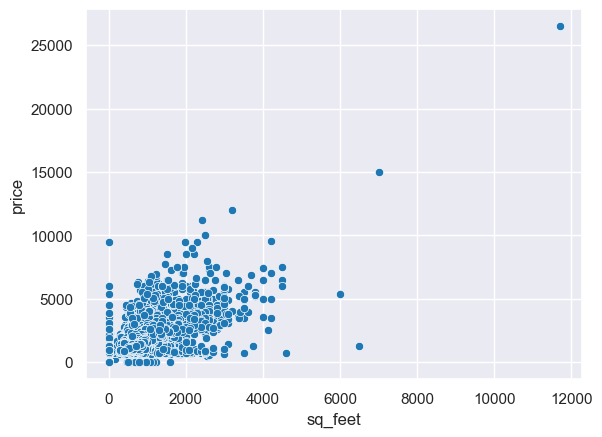

In [9]:
#check the linearity between price and other numeric column
for col in rent.drop("price",axis=1).select_dtypes("number").columns:
    sns.scatterplot(data=rent,x=col,y="price")
# there is certainly a linear relationship between the two variable    

In [10]:
print(rent.columns)
rent.smoking.value_counts(normalize=True)

Index(['address', 'lease_term', 'type', 'price', 'beds', 'baths', 'sq_feet',
       'furnishing', 'availability_date', 'smoking', 'cats', 'dogs',
       'city_province'],
      dtype='object')


smoking
Non-Smoking            0.972178
Smoke Free Building    0.016911
Smoking Allowed        0.006671
Negotiable             0.004241
Name: proportion, dtype: float64

In [11]:
#more regrouping sub categories under 1% of the total counts of the column to avoid overfitting
new_rent=rent.assign(
    lease_term=rent.lease_term.map({"Less than a Year":"Short Term",
                                   "Long Term":"Long Term",
                                   "Negotiable":"Negotiable",
                                   "Short Term":"Short Term"}),
    type=rent.type.replace({"Loft":"Others","Acreage":"Others","Vacation Home":"Others","Mobile":"Others"}),
    beds=rent.beds.replace({"5 Beds":"4+","6 Beds":"4+","7 Beds":"4+","8 Beds":"4+","9 Beds":"4+"}),
    baths=rent.baths.replace({"4":"3.5+","4.5":"3.5+","5":"3.5+","5.5":"3.5+","6":"3.5+","6.5":"3.5+","7":"3.5+","7.5":"3.5+","0":"0-1","1":"0-1"}),
    furnishing=rent.furnishing.replace({"Unfurnished, Negotiable":"Unfurnished","Negotiable":"Unfurnished"}),
    availability_date=rent.availability_date.replace({"Negotiable":"not right away"}),
    smoking=rent.smoking.replace({"Smoke Free Building":"Non-Smoking","Negotiable":"Smoking Allowed"})
).drop("address",axis=1)

In [12]:
for col in new_rent.select_dtypes("object"):
    print(new_rent[col].value_counts(normalize=True))

lease_term
Long Term     0.926979
Negotiable    0.054352
Short Term    0.018669
Name: proportion, dtype: float64
type
Apartment        0.629260
Condo Unit       0.098878
Townhouse        0.069969
House            0.065781
Basement         0.063091
Main Floor       0.033614
Duplex           0.020013
Room For Rent    0.017945
Others           0.001448
Name: proportion, dtype: float64
beds
2 Beds    0.394891
1 Bed     0.358277
3 Beds    0.143352
Studio    0.059420
4 Beds    0.032528
4+        0.011532
Name: proportion, dtype: float64
baths
0-1     0.640844
2       0.199307
2.5     0.080881
1.5     0.039665
3.5     0.017790
3       0.015669
3.5+    0.005844
Name: proportion, dtype: float64
furnishing
Unfurnished    0.919636
Furnished      0.080364
Name: proportion, dtype: float64
availability_date
Immediate         0.566737
not right away    0.433263
Name: proportion, dtype: float64
smoking
Non-Smoking        0.989088
Smoking Allowed    0.010912
Name: proportion, dtype: float64
cats
True  

### Catplot

##### Use Catplot (barplot) to explore the distribution + relationship between the catogarical values and the 'price'

<Figure size 800x600 with 0 Axes>

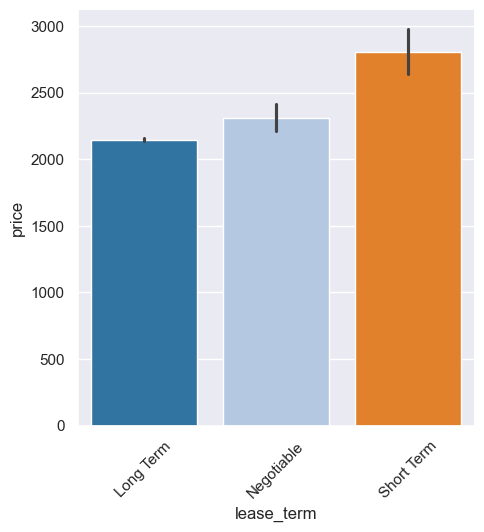

<Figure size 800x600 with 0 Axes>

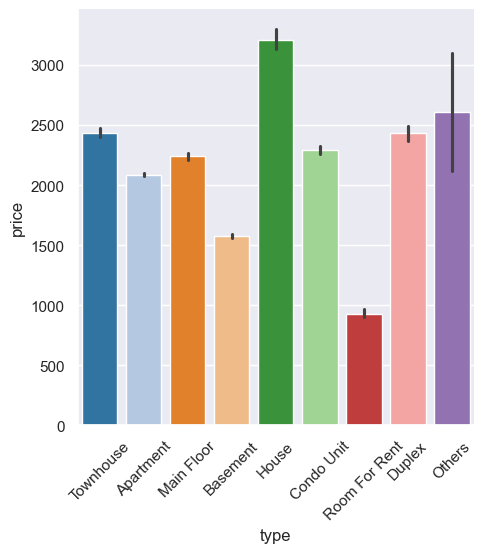

<Figure size 800x600 with 0 Axes>

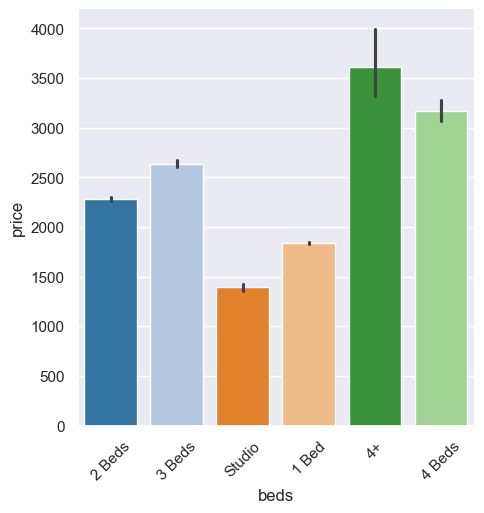

<Figure size 800x600 with 0 Axes>

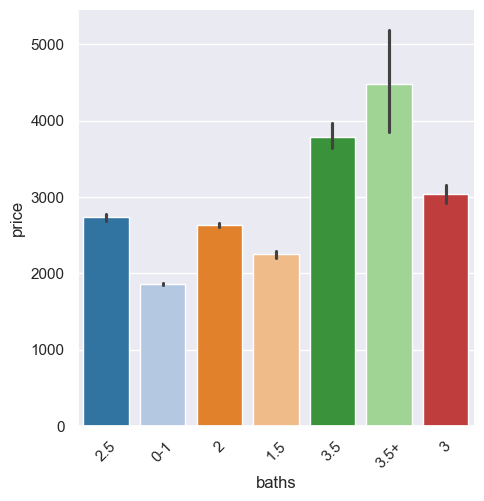

<Figure size 800x600 with 0 Axes>

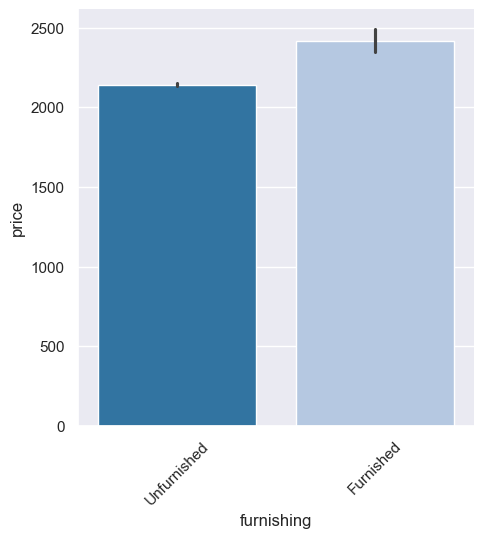

<Figure size 800x600 with 0 Axes>

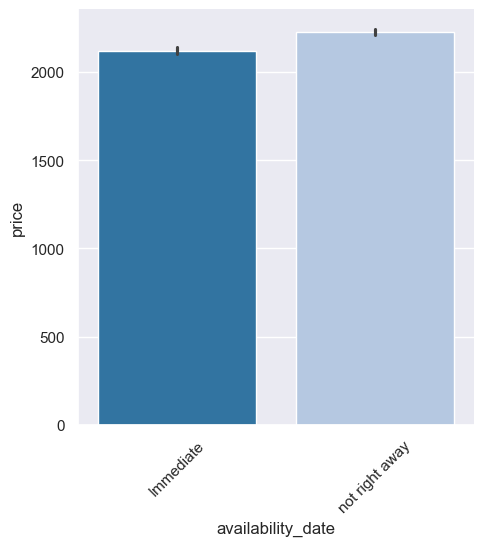

<Figure size 800x600 with 0 Axes>

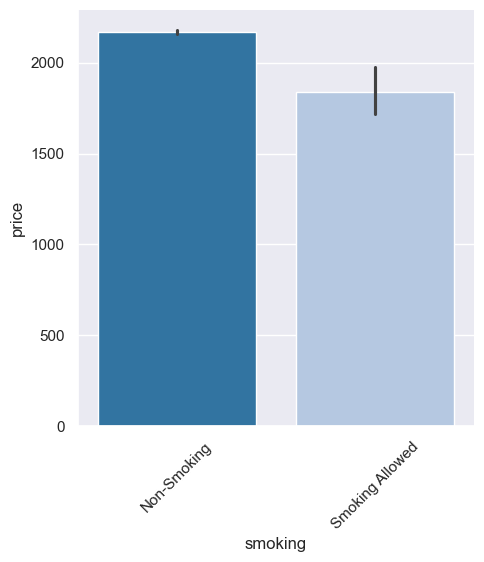

<Figure size 800x600 with 0 Axes>

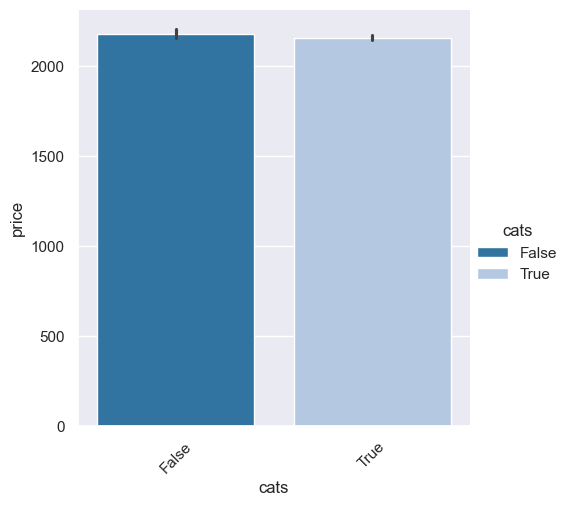

<Figure size 800x600 with 0 Axes>

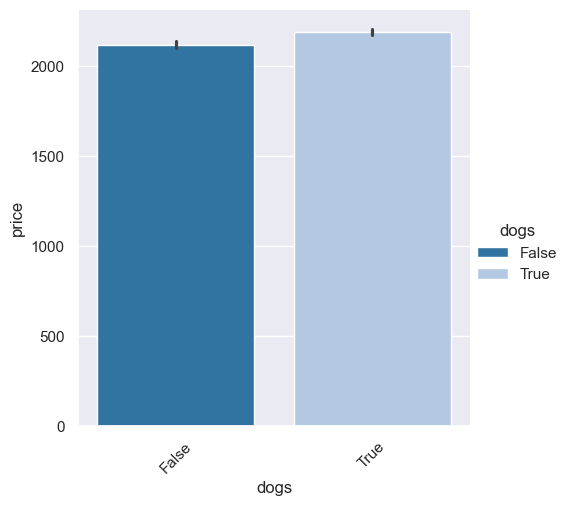

In [15]:
for col in new_rent.drop("city_province",axis=1).select_dtypes("object"):
    plt.figure(figsize=(8,6))
    sns.catplot(data=new_rent,x=col,y="price",kind="bar",hue=col)
    plt.xticks(rotation=45)

#### More data cleanning

In [17]:
new_rent.sq_feet.value_counts()
#there are 0 sq_feet, it needs to be handled.

sq_feet
0.0       625
1000.0    380
600.0     357
900.0     344
700.0     327
         ... 
2799.0      1
1272.0      1
1508.0      1
279.0       1
334.0       1
Name: count, Length: 1541, dtype: int64

In [18]:
new_rent.query("sq_feet==0")

,lease_term,type,price,beds,baths,sq_feet,furnishing,availability_date,smoking,cats,dogs,city_province
160,Long Term,Apartment,875.0,2 Beds,0-1,0.0,Unfurnished,Immediate,Non-Smoking,True,True,"Bonnyville, Alberta"
161,Long Term,Apartment,875.0,2 Beds,0-1,0.0,Unfurnished,Immediate,Non-Smoking,True,True,"Bonnyville, Alberta"
162,Long Term,Apartment,1035.0,1 Bed,0-1,0.0,Unfurnished,Immediate,Non-Smoking,True,True,"Bonnyville, Alberta"
163,Long Term,Apartment,1005.0,2 Beds,0-1,0.0,Unfurnished,Immediate,Non-Smoking,True,True,"Bonnyville, Alberta"
165,Long Term,Apartment,855.0,Studio,0-1,0.0,Unfurnished,Immediate,Non-Smoking,True,True,"Bonnyville, Alberta"
...,...,...,...,...,...,...,...,...,...,...,...,...
25756,Long Term,Apartment,835.0,Studio,0-1,0.0,Unfurnished,Immediate,Non-Smoking,True,True,"Yorkton, Saskatchewan"
25757,Long Term,Apartment,960.0,1 Bed,0-1,0.0,Unfurnished,Immediate,Non-Smoking,True,True,"Yorkton, Saskatchewan"
25758,Long Term,Apartment,1300.0,2 Beds,0-1,0.0,Unfurnished,Immediate,Non-Smoking,True,True,"Yorkton, Saskatchewan"
25762,Long Term,Apartment,945.0,Studio,0-1,0.0,Unfurnished,Immediate,Non-Smoking,True,True,"Yorkton, Saskatchewan"


In [19]:
#drop all the rows with sq_feet ==0! because they maybe errors 
#or just another null values.
indx=new_rent.query("sq_feet==0").index
new_rent.drop(indx,axis=0,inplace=True)
new_rent.query("sq_feet==0")

,lease_term,type,price,beds,baths,sq_feet,furnishing,availability_date,smoking,cats,dogs,city_province


In [20]:
new_rent.head()

,lease_term,type,price,beds,baths,sq_feet,furnishing,availability_date,smoking,cats,dogs,city_province
0,Long Term,Townhouse,2495.0,2 Beds,2.5,1403.0,Unfurnished,Immediate,Non-Smoking,True,True,"Airdrie, Alberta"
1,Long Term,Townhouse,2695.0,3 Beds,2.5,1496.0,Unfurnished,Immediate,Non-Smoking,True,True,"Airdrie, Alberta"
2,Long Term,Townhouse,2295.0,2 Beds,2.5,1180.0,Unfurnished,Immediate,Non-Smoking,True,True,"Airdrie, Alberta"
3,Long Term,Townhouse,2095.0,2 Beds,2.5,1403.0,Unfurnished,not right away,Non-Smoking,True,True,"Airdrie, Alberta"
4,Long Term,Townhouse,2495.0,2 Beds,2.5,1403.0,Unfurnished,Immediate,Non-Smoking,True,True,"Airdrie, Alberta"


In [21]:
#remainning null valus in the data sets
new_rent.loc[new_rent.sq_feet.isna()]

,lease_term,type,price,beds,baths,sq_feet,furnishing,availability_date,smoking,cats,dogs,city_province
963,Negotiable,Townhouse,1200.0,1 Bed,0-1,NaN,Unfurnished,Immediate,Non-Smoking,False,False,"Calgary, Alberta"
2566,Negotiable,Room For Rent,1500.0,4+,3,NaN,Furnished,Immediate,Non-Smoking,False,False,"Calgary, Alberta"
10268,Negotiable,Townhouse,1200.0,1 Bed,0-1,NaN,Unfurnished,Immediate,Non-Smoking,False,False,"Calgary, Alberta"
11818,Negotiable,Room For Rent,1500.0,4+,3,NaN,Furnished,Immediate,Non-Smoking,False,False,"Calgary, Alberta"


In [22]:
#All the null values are eliminated
new_rent.dropna(inplace=True)
new_rent.isna().sum()

lease_term           0
type                 0
price                0
beds                 0
baths                0
sq_feet              0
furnishing           0
availability_date    0
smoking              0
cats                 0
dogs                 0
city_province        0
dtype: int64

In [23]:
# to make a copy for safety
new_rent_copy=new_rent.copy(deep=True)

#### End of Step 2: EDA - Data Cleanning + Preprossing + Visualisation

## Step 3: Statistical Analysis

### Create model with original columns

In [27]:
#creating independent and target variables
X=new_rent.drop("price",axis=1)
y=new_rent["price"]

### 1. Check linearity

In [29]:
#performing statistical analysis
#check 1 linearity
import statsmodels.api as sm
X=pd.get_dummies(X,drop_first=True).replace({True:1,False:0})
X=sm.add_constant(X)
model=sm.OLS(y,X).fit()
model.summary()
#Lots of coefficients of city_province is over 0.05, maybe city isn't impacting 
#that much, try only province

/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_4084/887824836.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X=pd.get_dummies(X,drop_first=True).replace({True:1,False:0})


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     157.0
Date:                Sat, 19 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:23:55   Log-Likelihood:            -1.4281e+05
No. Observations:               18708   AIC:                         2.861e+05
Df Residuals:                   18462   BIC:                         2.880e+05
Df Model:                         245                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                1365.4494     89.671     15.227      0.000    1189.686    1541.213
sq_feet                                                 0.8740      0.013     65.760      0.000       0.848       0.900
lease_term_Negotiable                                 194.1101     17.765     10.927      0.000     159.289     228.931
lease_term_Short Term                                 426.3717     28.259     15.088      0.000     370.981     481.763
type_Basement                                        -500.2227     17.435    -28.690      0.000    -534.397    -466.048
type_Condo Unit                                        30.4289     14.858      2.048      0.041       1.305      59.552
type_Duplex                                          -367.1497     29.866    -12.293      0.000    -425.690    -308.610
type_House                                           -168.3627     23.359     -7.208      0.000    -214.149    -122.576
type_Main Floor                                      -378.1931     24.209    -15.622      0.000    -425.645    -330.741
type_Others                                           211.5285     98.446      2.149      0.032      18.565     404.492
type_Room For Rent                                  -2093.4746     31.948    -65.527      0.000   -2156.096   -2030.853
type_Townhouse                                       -239.6593     18.472    -12.974      0.000    -275.866    -203.452
beds_2 Beds                                           117.7548     10.452     11.266      0.000      97.268     138.242
beds_3 Beds                                           207.3625     17.405     11.914      0.000     173.246     241.479
beds_4 Beds                                            92.1431     30.664      3.005      0.003      32.038     152.248
beds_4+                                               279.1600     43.590      6.404      0.000     193.720     364.600
beds_Studio                                          -234.9165     18.008    -13.045      0.000    -270.214    -199.619
baths_1.5                                             127.5673     20.743      6.150      0.000      86.909     168.225
baths_2                                               315.8283     11.785     26.798      0.000     292.728     338.929
baths_2.5                                             238.0365     20.401     11.668      0.000     198.049     278.024
baths_3                                               368.6600     34.899     10.563      0.000     300.254     437.066
baths_3.5                                             639.9093     37.111     17.243      0.000     567.167     712.651
baths_3.5+                                           1081.7928     55.979     19.32

<Axes: ylabel='None'>

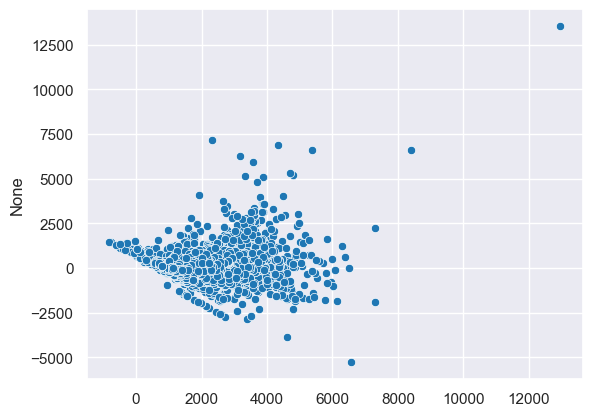

In [30]:
sns.scatterplot(data=new_rent,x=model.predict(),y=model.resid)

### 2. Check independency

<p>The Durbin-Waston is 1.56, so it's suggesting the errors are independent</p>

<Figure size 800x600 with 0 Axes>

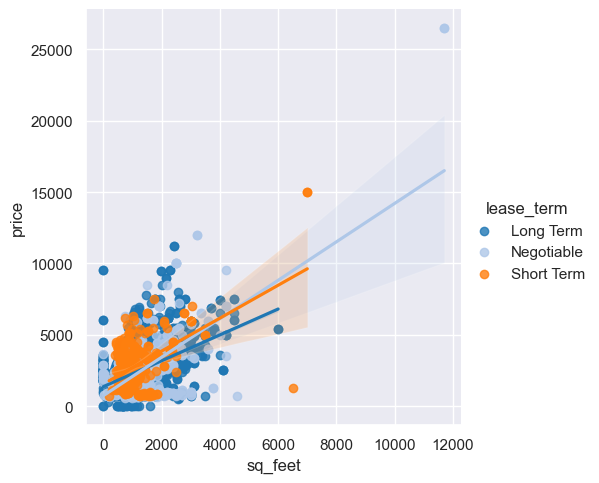

<Figure size 800x600 with 0 Axes>

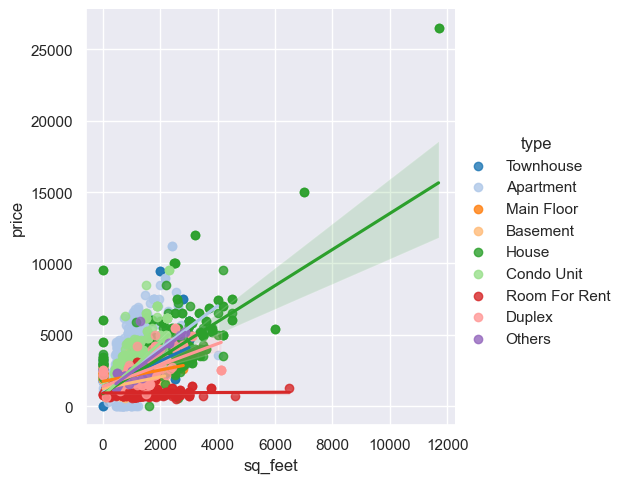

<Figure size 800x600 with 0 Axes>

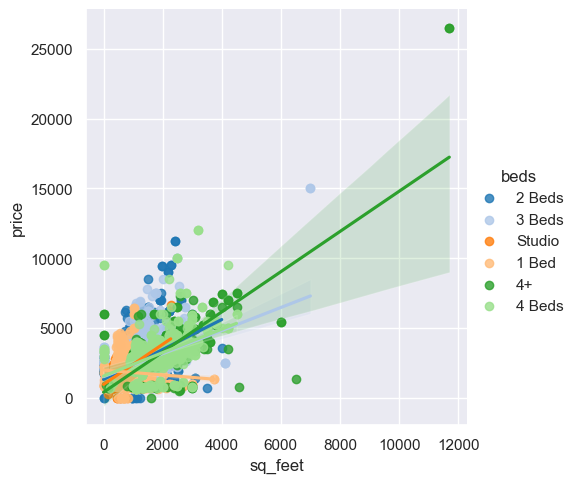

<Figure size 800x600 with 0 Axes>

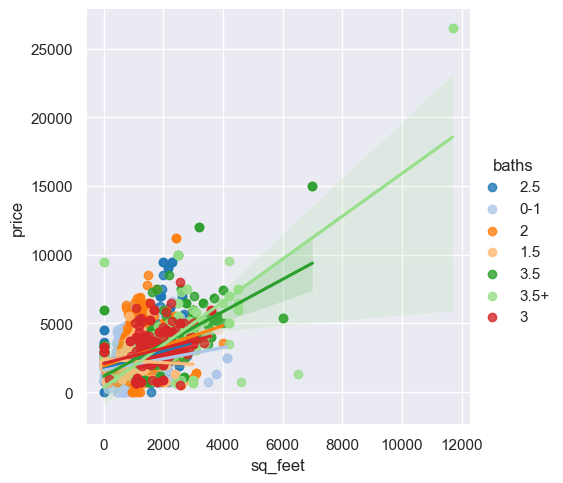

<Figure size 800x600 with 0 Axes>

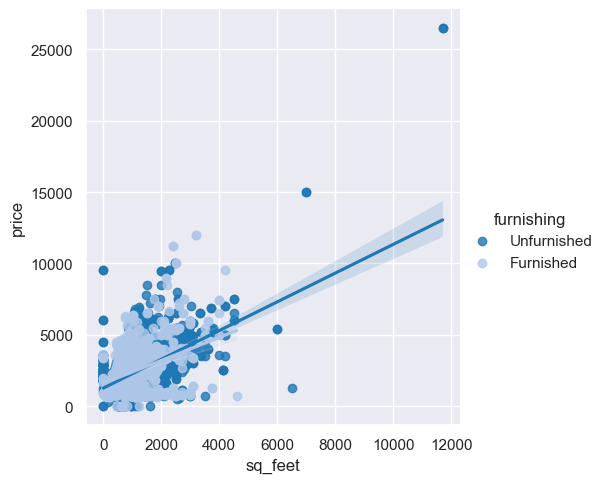

<Figure size 800x600 with 0 Axes>

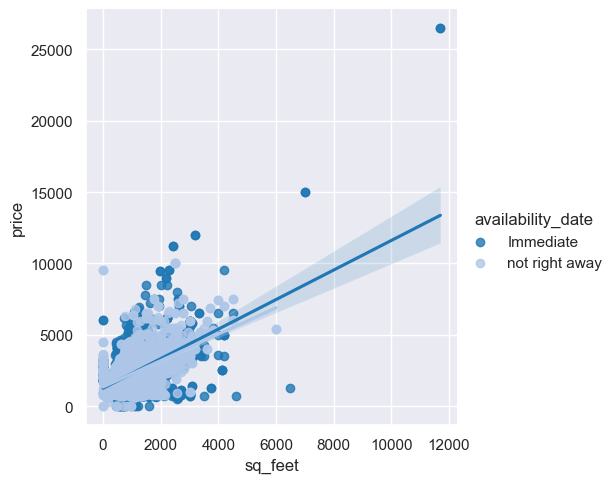

<Figure size 800x600 with 0 Axes>

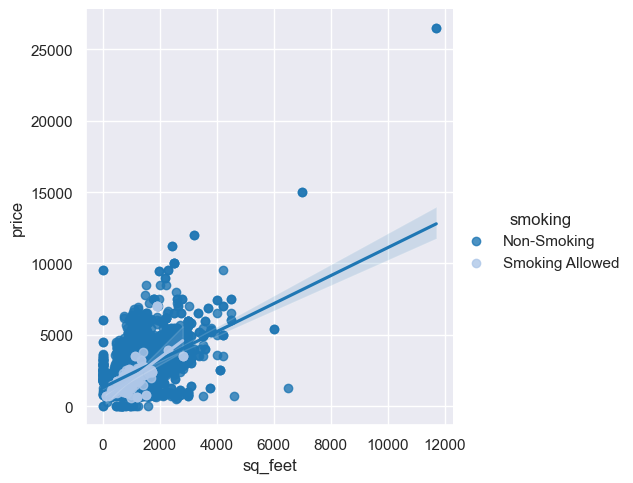

<Figure size 800x600 with 0 Axes>

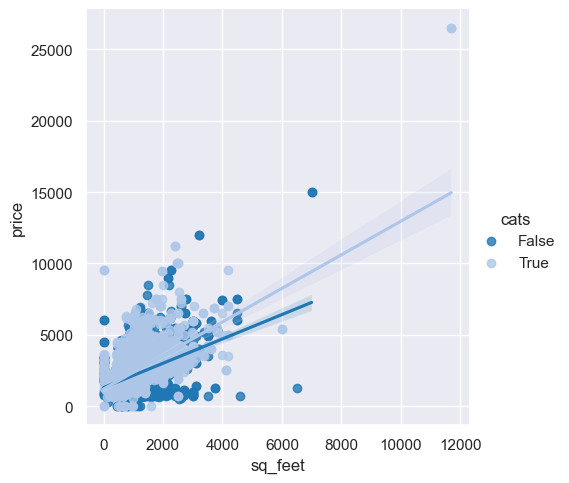

<Figure size 800x600 with 0 Axes>

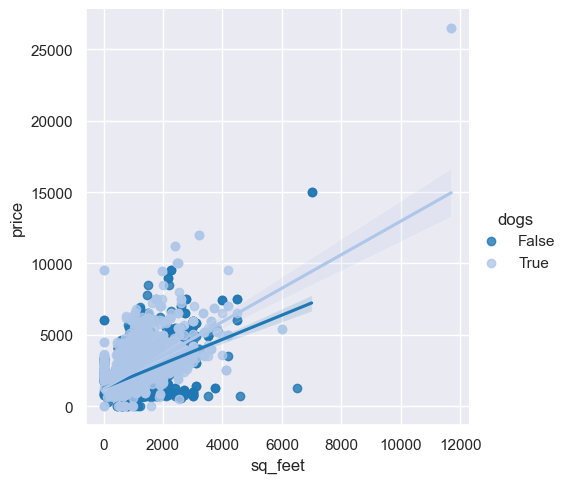

In [33]:
for col in new_rent.drop("city_province",axis=1).select_dtypes("object"):
    plt.figure(figsize=(8,6))
    sns.lmplot(data=new_rent,x="sq_feet",y="price",hue=col)
# there is no clear sub regression between price and sq_feet in terms of 
# different categories. Therefore, no interaction terms shall be created

<h3>Create a polynomial feature Model1 </h3>

In [35]:
#create a polynomial terms for sq_feet, and recreate the province column
new_rent1=(new_rent.assign(sq_feet_sq=new_rent.sq_feet**2,
                           province=new_rent.city_province.str.split(",",n=1,expand=True)[1]
                )
 .drop("city_province",axis=1))


X1=new_rent1.drop("price",axis=1)
y1=new_rent1.price
import statsmodels.api as sm
X1=pd.get_dummies(X1,drop_first=True).replace({True:1,False:0})
X1=sm.add_constant(X1)
model1=sm.OLS(y1,X1).fit()
model1.summary()

/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_4084/295997610.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X1=pd.get_dummies(X1,drop_first=True).replace({True:1,False:0})


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     785.9
Date:                Sat, 19 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:24:01   Log-Likelihood:            -1.4471e+05
No. Observations:               18708   AIC:                         2.895e+05
Df Residuals:                   18671   BIC:                         2.898e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                1910.3970     24.355     78.440      0.000    1862.659    1958.135
sq_feet                                 0.1144      0.022      5.094      0.000       0.070       0.158
sq_feet_sq                              0.0002   3.76e-06     41.591      0.000       0.000       0.000
lease_term_Negotiable                 156.1679     19.452      8.028      0.000     118.040     194.296
lease_term_Short Term                 413.0143     30.962     13.339      0.000     352.325     473.704
type_Basement                        -374.6259     18.670    -20.065      0.000    -411.221    -338.031
type_Condo Unit                       111.4867     16.060      6.942      0.000      80.007     142.966
type_Duplex                          -290.5020     32.669     -8.892      0.000    -354.537    -226.467
type_House                            -57.6782     25.285     -2.281      0.023    -107.240      -8.117
type_Main Floor                      -207.3557     26.264     -7.895      0.000    -258.835    -155.876
type_Others                           250.3762    105.474      2.374      0.018      43.638     457.115
type_Room For Rent                  -1884.8393     35.029    -53.808      0.000   -1953.500   -1816.179
type_Townhouse                       -154.9599     19.992     -7.751      0.000    -194.147    -115.773
beds_2 Beds                           167.8875     11.571     14.510      0.000     145.208     190.567
beds_3 Beds                           303.7839     19.232     15.796      0.000     266.088     341.480
beds_4 Beds                           221.9557     33.710      6.584      0.000     155.882     288.030
beds_4+                               216.9858     47.651      4.554      0.000     123.586     310.386
beds_Studio                          -332.3608     19.706    -16.866      0.000    -370.987    -293.735
baths_1.5                             240.7928     22.524     10.691      0.000     196.644     284.942
baths_2                               452.0320     12.710     35.565      0.000     427.119     476.945
baths_2.5                             445.6186     22.370     19.920      0.000     401.771     489.466
baths_3                               629.1173     38.105     16.510      0.000     554.429     703.806
baths_3.5                             901.8951     40.486     22.277      0.000     822.539     981.251
baths_3.5+                           1011.0724     61.102     16.547      0.000     891.308    1130.837
furnishing_Unfurnished               -465.8346     17.094    -27.251      0.000    -499.341    -432.329
availability_date_not right away       22.5135      8.403      2.679      0.007       6.044      38.983
smoking_Smoking Allowed               -83.3233     41.891     -1.98

### The r2 score comes down, and Durbin-waston is 1.13 suggesting less independent of residual errors. However, all the coefficients are more relevant than ever.

<Axes: ylabel='None'>

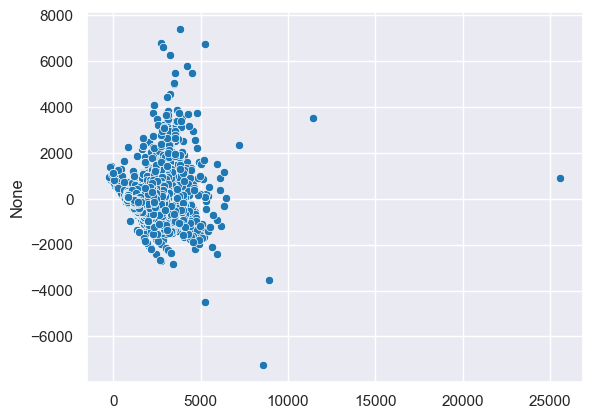

In [37]:
sns.scatterplot(data=new_rent1,x=model1.predict(),y=model1.resid)
#2 check for independence of errors
# r2 score come down from 0.646 to 0.602, but most of coefficients 
#are under 0.05. 
# the residual plot is somewhat independent. 
# The durbin-waston is 1.13, outside [1.5,2], which means 
# errors are not independent.


### Create the model2 with square items 

In [39]:
# Next try, square sq_feet, log price feature
new_rent2=new_rent.assign(sq_feet_sq=new_rent.sq_feet**2)
X2=new_rent2.drop("price",axis=1)
y2=np.log(new_rent2["price"])
import statsmodels.api as sm
X2=pd.get_dummies(X2,drop_first=True).replace({True:1,False:0})
X2=sm.add_constant(X2)
model2=sm.OLS(y2,X2).fit()
model2.summary()

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_4084/383157719.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X2=pd.get_dummies(X2,drop_first=True).replace({True:1,False:0})
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1734: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 19 Oct 2024   Prob (F-statistic):                nan
Time:                        19:24:02   Log-Likelihood:                    nan
No. Observations:               18708   AIC:                               nan
Df Residuals:                   18461   BIC:                               nan
Df Model:                         246                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                      nan        nan        nan        nan         nan         nan
sq_feet                                                    nan        nan        nan        nan         nan         nan
sq_feet_sq                                                 nan        nan        nan        nan         nan         nan
lease_term_Negotiable                                      nan        nan        nan        nan         nan         nan
lease_term_Short Term                                      nan        nan        nan        nan         nan         nan
type_Basement                                              nan        nan        nan        nan         nan         nan
type_Condo Unit                                            nan        nan        nan        nan         nan         nan
type_Duplex                                                nan        nan        nan        nan         nan         nan
type_House                                                 nan        nan        nan        nan         nan         nan
type_Main Floor                                            nan        nan        nan        nan         nan         nan
type_Others                                                nan        nan        nan        nan         nan         nan
type_Room For Rent                                         nan        nan        nan        nan         nan         nan
type_Townhouse                                             nan        nan        nan        nan         nan         nan
beds_2 Beds                                                nan        nan        nan        nan         nan         nan
beds_3 Beds                                                nan        nan        nan        nan         nan         nan
beds_4 Beds                                                nan        nan        nan        nan         nan         nan
beds_4+                                                    nan        nan        nan        nan         nan         nan
beds_Studio                                                nan        nan        nan        nan         nan         nan
baths_1.5                                                  nan        nan        nan        nan         nan         nan
baths_2                                                    nan        nan        nan        nan         nan         nan
baths_2.5                                                  nan        nan        nan        nan         nan         nan
baths_3                                                    nan        nan        nan        nan         nan         nan
baths_3.5                                                  nan        nan        na

<p>It's a mess, and not working</p>

### Create the model3 without square item

In [42]:
# run second model without sq_feet_sq and province
new_rent3=(new_rent.assign(
                province=new_rent.city_province.str.split(",",n=1,expand=True)[1]
                )
 .drop("city_province",axis=1))

X3=new_rent3.drop("price",axis=1)
y3=new_rent3.price
import statsmodels.api as sm
X3=pd.get_dummies(X3,drop_first=True).replace({True:1,False:0})
X3=sm.add_constant(X3)
model3=sm.OLS(y3,X3).fit()
model3.summary()

/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_4084/441862688.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X3=pd.get_dummies(X3,drop_first=True).replace({True:1,False:0})


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     694.6
Date:                Sat, 19 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:24:02   Log-Likelihood:            -1.4554e+05
No. Observations:               18708   AIC:                         2.912e+05
Df Residuals:                   18672   BIC:                         2.914e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                1513.4951     23.422     64.619      0.000    1467.586    1559.404
sq_feet                                 0.8305      0.015     55.054      0.000       0.801       0.860
lease_term_Negotiable                 172.8117     20.329      8.501      0.000     132.966     212.658
lease_term_Short Term                 441.9646     32.356     13.659      0.000     378.544     505.385
type_Basement                        -414.2002     19.490    -21.252      0.000    -452.402    -375.998
type_Condo Unit                       106.7590     16.787      6.360      0.000      73.856     139.663
type_Duplex                          -327.3502     34.136     -9.590      0.000    -394.259    -260.441
type_House                           -105.8402     26.402     -4.009      0.000    -157.591     -54.089
type_Main Floor                      -251.0720     27.431     -9.153      0.000    -304.839    -197.305
type_Others                           186.3912    110.237      1.691      0.091     -29.683     402.466
type_Room For Rent                  -1991.7287     36.516    -54.544      0.000   -2063.304   -1920.153
type_Townhouse                       -176.8365     20.890     -8.465      0.000    -217.783    -135.890
beds_2 Beds                            69.2840     11.838      5.853      0.000      46.081      92.487
beds_3 Beds                           137.5639     19.663      6.996      0.000      99.022     176.106
beds_4 Beds                            24.1285     34.883      0.692      0.489     -44.246      92.503
beds_4+                               189.1413     49.803      3.798      0.000      91.523     286.760
beds_Studio                          -223.3720     20.415    -10.941      0.000    -263.388    -183.356
baths_1.5                             179.3670     23.493      7.635      0.000     133.319     225.415
baths_2                               398.7327     13.218     30.167      0.000     372.825     424.641
baths_2.5                             305.0491     23.115     13.197      0.000     259.742     350.356
baths_3                               476.6333     39.645     12.023      0.000     398.926     554.341
baths_3.5                             777.5952     42.203     18.425      0.000     694.873     860.318
baths_3.5+                           1179.5706     63.727     18.510      0.000    1054.660    1304.481
furnishing_Unfurnished               -457.0973     17.867    -25.584      0.000    -492.117    -422.077
availability_date_not right away       15.0192      8.781      1.710      0.087      -2.192      32.231
smoking_Smoking Allowed               -80.6454     43.787     -1.842      0.066    -166.472       5.181
cats_True                             -90.8723     17.863     -5.08

<p>Low r2 score, low Durbin Waston, p-values for coefficients are under 5% mostly, so they are relavant. </p>

### Create Model4 with a polynomial feature and city_province to prioritize r2_score

In [45]:
new_rent4=new_rent.assign(sq_feet_sq=new_rent.sq_feet**2)
X4=new_rent4.drop("price",axis=1)
y4=new_rent4.price
import statsmodels.api as sm
X4=pd.get_dummies(X4,drop_first=True).replace({True:1,False:0})
X4=sm.add_constant(X4)
model4=sm.OLS(y4,X4).fit()
model4.summary()

/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_4084/230649254.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X4=pd.get_dummies(X4,drop_first=True).replace({True:1,False:0})


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     181.4
Date:                Sat, 19 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:24:03   Log-Likelihood:            -1.4185e+05
No. Observations:               18708   AIC:                         2.842e+05
Df Residuals:                   18461   BIC:                         2.861e+05
Df Model:                         246                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                1753.2890     85.613     20.479      0.000    1585.479    1921.099
sq_feet                                                 0.1968      0.020      9.985      0.000       0.158       0.235
sq_feet_sq                                              0.0001   3.26e-06     44.746      0.000       0.000       0.000
lease_term_Negotiable                                 178.5983     16.877     10.582      0.000     145.517     211.680
lease_term_Short Term                                 398.6854     26.849     14.849      0.000     346.058     451.312
type_Basement                                        -463.4641     16.581    -27.951      0.000    -495.964    -430.964
type_Condo Unit                                        36.1319     14.114      2.560      0.010       8.468      63.796
type_Duplex                                          -330.0270     28.380    -11.629      0.000    -385.655    -274.399
type_House                                           -120.0545     22.214     -5.404      0.000    -163.596     -76.513
type_Main Floor                                      -331.0073     23.019    -14.380      0.000    -376.127    -285.888
type_Others                                           268.1818     93.517      2.868      0.004      84.879     451.484
type_Room For Rent                                  -1988.5021     30.436    -65.333      0.000   -2048.160   -1928.844
type_Townhouse                                       -218.2568     17.552    -12.435      0.000    -252.660    -183.853
beds_2 Beds                                           208.7100     10.134     20.596      0.000     188.847     228.573
beds_3 Beds                                           359.7414     16.880     21.312      0.000     326.656     392.827
beds_4 Beds                                           274.7931     29.411      9.343      0.000     217.145     332.442
beds_4+                                               306.2155     41.408      7.395      0.000     225.052     387.379
beds_Studio                                          -333.7457     17.247    -19.351      0.000    -367.551    -299.940
baths_1.5                                             184.1352     19.743      9.327      0.000     145.437     222.833
baths_2                                               368.5417     11.256     32.742      0.000     346.479     390.605
baths_2.5                                             374.8276     19.617     19.107      0.000     336.376     413.279
baths_3                                               517.2411     33.315     15.526      0.000     451.941     582.541
baths_3.5                                             766.3808     35.363     21.67

<h4>The model4 has delivered a much higher r2 score. Although it has lots
of coefficients with >0.05 of p-values. We scarifice relavance for accuracy. Model4 will be our base to build linear regression model</h4>

### 3 check Normality of Errors

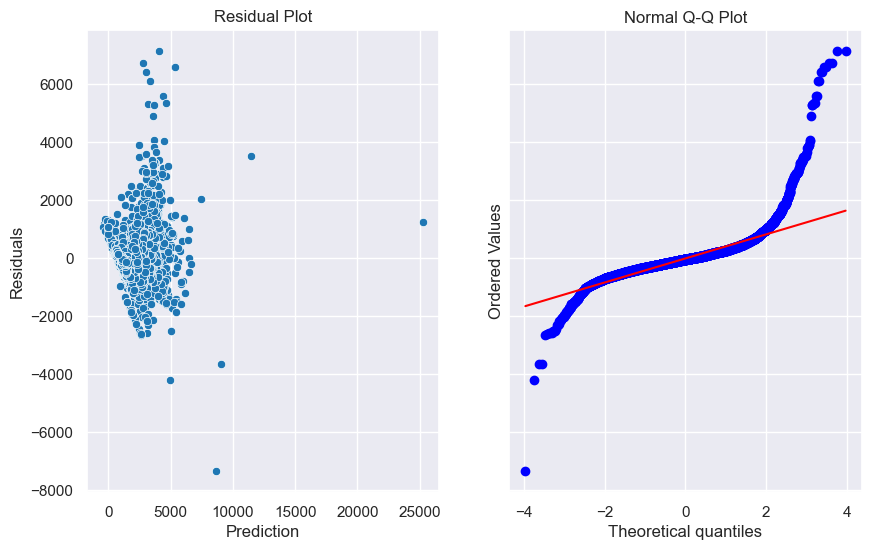

In [48]:
# The result is a mess. Moving on with model1
# check 3. Normality of Errors
import scipy.stats as stats
import matplotlib.pyplot as plt
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")  

residual_analysis_plots(model4)

In [49]:
#4. No Perfect Multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

a=pd.Series(
        [vif(X4.values, i) for i in range(X4.shape[1])],
        index=X4.columns).sort_values(ascending=False)
print(a)
print(a.unique())

const                                         599.823067
city_province_Calgary, Alberta                139.296020
city_province_Edmonton, Alberta                59.130871
city_province_Toronto, Ontario                 41.505165
city_province_Montréal, Quebec                 30.559011
                                                 ...    
city_province_Vanier, Ontario                   1.030502
city_province_Glace Bay, Nova Scotia            1.030499
city_province_Ayr, Ontario                      1.030498
city_province_Fort Erie, Ontario                1.030496
city_province_Port Moody, British Columbia      1.030350
Length: 247, dtype: float64
[599.82306674 139.29602008  59.13087105  41.50516508  30.55901135
  24.47730505  18.85955135   8.88240666   7.97574313   7.38020946
   6.93640899   6.49432674   6.43000842   6.37456941   5.50571113
   5.03185318   5.02950653   4.56240214   4.55499075   4.44515755
   4.22720265   4.09466952   3.95648972   3.7771644    3.61643148
   3.60117792  

<p>Good amount of variables are above 5, most are located in the same cities,
which indicates that most of the independent variables are correlated
with each other. We can compromise that for accuracy</p>


<h4>5.Check equal variance of Errors</h4>

<Axes: ylabel='None'>

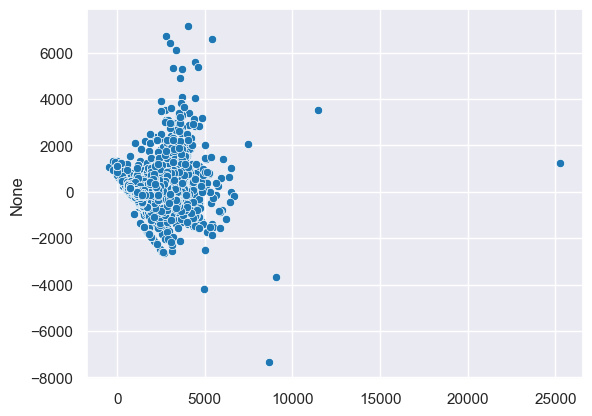

In [52]:
#5 Equal Variance of Errors
sns.scatterplot(x=model4.predict(),y=model4.resid)


#### Dots are not very scattered equally from the center, but we can work with this

<h4>6.check for outsiders</h4>

In [55]:
# codes take forever to run

# influence = model1.get_influence()
# inf_summary_df = influence.summary_frame()
# inf_summary_df.head()
# inf_summary_df["cooks_d"].sort_values(ascending=False).round(2)

#### All the cooks_id are below 0.5, which means there are no outliers

#### Conclusion: Model 4 has the best r score so far, so We are picking Model4 for model buildings.
#### Model4 has flaws such as semi perfect multi-colinearity, residuals are almost independent, nonequal variances. However, it gives us high accuracy.

### End of Step 3: Statistical Analysis

## Step 4 : Model Buildings

## LassoCV Model by Flora Wong

In [61]:
df_la = new_rent.reset_index(drop=True)
df_la

,lease_term,type,price,beds,baths,sq_feet,furnishing,availability_date,smoking,cats,dogs,city_province
0,Long Term,Townhouse,2495.0,2 Beds,2.5,1403.0,Unfurnished,Immediate,Non-Smoking,True,True,"Airdrie, Alberta"
1,Long Term,Townhouse,2695.0,3 Beds,2.5,1496.0,Unfurnished,Immediate,Non-Smoking,True,True,"Airdrie, Alberta"
2,Long Term,Townhouse,2295.0,2 Beds,2.5,1180.0,Unfurnished,Immediate,Non-Smoking,True,True,"Airdrie, Alberta"
3,Long Term,Townhouse,2095.0,2 Beds,2.5,1403.0,Unfurnished,not right away,Non-Smoking,True,True,"Airdrie, Alberta"
4,Long Term,Townhouse,2495.0,2 Beds,2.5,1403.0,Unfurnished,Immediate,Non-Smoking,True,True,"Airdrie, Alberta"
...,...,...,...,...,...,...,...,...,...,...,...,...
18703,Long Term,Apartment,920.0,Studio,0-1,400.0,Unfurnished,Immediate,Non-Smoking,True,True,"Yorkton, Saskatchewan"
18704,Long Term,Apartment,1450.0,3 Beds,0-1,810.0,Unfurnished,Immediate,Non-Smoking,True,True,"Yorkton, Saskatchewan"
18705,Long Term,Apartment,1125.0,1 Bed,0-1,520.0,Unfurnished,Immediate,Non-Smoking,True,True,"Yorkton, Saskatchewan"
18706,Long Term,Apartment,920.0,Studio,0-1,400.0,Unfurnished,Immediate,Non-Smoking,True,True,"Yorkton, Saskatchewan"


#### Encoding Categorical Values

In [63]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder

In [64]:
lassocv_encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols = lassocv_encoder.fit_transform(df_la[['lease_term', 'type', 'beds', 'baths', 'furnishing',
       'availability_date', 'smoking', 'cats', 'dogs', 'city_province']])

# get_feature_names_out() returns the transformed feature names
new_df = pd.DataFrame(encoded_cols, columns = lassocv_encoder.get_feature_names_out(['lease_term', 'type', 'beds', 'baths', 'furnishing',
       'availability_date', 'smoking', 'cats', 'dogs','city_province']))

new_df.head()

,lease_term_Negotiable,lease_term_Short Term,type_Basement,type_Condo Unit,type_Duplex,type_House,type_Main Floor,type_Others,type_Room For Rent,type_Townhouse,...,"city_province_Wetaskiwin, Alberta","city_province_Whitby, Ontario","city_province_Whitchurch-Stouffville, Ontario","city_province_White Rock, British Columbia","city_province_Whitecourt, Alberta","city_province_Windsor, Ontario","city_province_Winnipeg, Manitoba","city_province_Woodstock, Ontario","city_province_Wyoming, Ontario","city_province_Yorkton, Saskatchewan"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
df_encoded= df_la.drop(columns=['lease_term', 'type', 'beds', 'baths', 'furnishing',
       'availability_date', 'smoking', 'cats', 'dogs', 'city_province']).join(new_df)
df_encoded.head()

,price,sq_feet,lease_term_Negotiable,lease_term_Short Term,type_Basement,type_Condo Unit,type_Duplex,type_House,type_Main Floor,type_Others,...,"city_province_Wetaskiwin, Alberta","city_province_Whitby, Ontario","city_province_Whitchurch-Stouffville, Ontario","city_province_White Rock, British Columbia","city_province_Whitecourt, Alberta","city_province_Windsor, Ontario","city_province_Winnipeg, Manitoba","city_province_Woodstock, Ontario","city_province_Wyoming, Ontario","city_province_Yorkton, Saskatchewan"
0,2495.0,1403.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2695.0,1496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2295.0,1180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2095.0,1403.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2495.0,1403.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
df_encoded.isnull().sum()

price                                  0
sq_feet                                0
lease_term_Negotiable                  0
lease_term_Short Term                  0
type_Basement                          0
                                      ..
city_province_Windsor, Ontario         0
city_province_Winnipeg, Manitoba       0
city_province_Woodstock, Ontario       0
city_province_Wyoming, Ontario         0
city_province_Yorkton, Saskatchewan    0
Length: 246, dtype: int64

In [67]:
df_encoded

,price,sq_feet,lease_term_Negotiable,lease_term_Short Term,type_Basement,type_Condo Unit,type_Duplex,type_House,type_Main Floor,type_Others,...,"city_province_Wetaskiwin, Alberta","city_province_Whitby, Ontario","city_province_Whitchurch-Stouffville, Ontario","city_province_White Rock, British Columbia","city_province_Whitecourt, Alberta","city_province_Windsor, Ontario","city_province_Winnipeg, Manitoba","city_province_Woodstock, Ontario","city_province_Wyoming, Ontario","city_province_Yorkton, Saskatchewan"
0,2495.0,1403.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2695.0,1496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2295.0,1180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2095.0,1403.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2495.0,1403.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18703,920.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18704,1450.0,810.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18705,1125.0,520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18706,920.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Spliting Data into training and Testing Data

In [69]:
X= df_encoded.drop(columns='price', axis=1)
y= df_encoded['price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [70]:
X.shape

(18708, 245)

In [71]:
y.shape

(18708,)

In [72]:
X_train.shape

(14966, 245)

In [73]:
X_test.shape

(3742, 245)

#### Polynomial Features (for numerical feature only)

In [75]:
# Select only numerical column ['sq_feet'] for polynomial transformation

numerical_cols = ['sq_feet']
categorical_cols = X.drop(columns='sq_feet', axis=1).columns

In [76]:
from sklearn.preprocessing import PolynomialFeatures

poly_convert = PolynomialFeatures(degree=2,include_bias=False)
X_train_numerical = poly_convert.fit_transform(X_train[numerical_cols])
X_test_numerical = poly_convert.transform(X_test[numerical_cols])

In [77]:
# Convert the transformed numerical data back to DataFrame

X_train_numerical_df = pd.DataFrame(X_train_numerical, columns=poly_convert.get_feature_names_out(numerical_cols))
X_test_numerical_df = pd.DataFrame(X_test_numerical, columns=poly_convert.get_feature_names_out(numerical_cols))

In [78]:
# Concatenate back the categorical columns (untouched) with the transformed numerical features

X_train_final = pd.concat([X_train_numerical_df, X_train[categorical_cols].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_numerical_df, X_test[categorical_cols].reset_index(drop=True)], axis=1)

In [79]:
X_train_final.shape

(14966, 246)

In [80]:
X_test_final.shape

(3742, 246)

#### Scaling, Standardization, Normalisation

In [82]:
from sklearn.preprocessing import StandardScaler
scaler_f = StandardScaler()
scaled_X_train_final = scaler_f.fit_transform(X_train_final)
scaled_X_test_final = scaler_f.transform(X_test_final)

#### Fitting Lasso Model

In [84]:
from sklearn.linear_model import LassoCV


lassocv_model = LassoCV(eps=0.001,n_alphas=200,cv=10, random_state=1)

lassocv_model.fit(scaled_X_train_final, y_train)

LassoCV(cv=10, n_alphas=200, random_state=1)

In [85]:
# Optimal alpha value
lassocv_model.alpha_

0.48898380654422025

In [86]:
lassocv_coef = lassocv_model.coef_
lassocv_coef

array([ 1.00893110e+02,  3.25040641e+02,  3.82943824e+01,  5.44184484e+01,
       -1.15447788e+02,  1.10538401e+01, -4.48096210e+01, -3.04671922e+01,
       -6.17434857e+01,  1.08186317e+01, -2.67468763e+02, -5.53172103e+01,
        9.71201638e+01,  1.25686731e+02,  5.07825842e+01,  2.81316643e+01,
       -7.56201604e+01,  3.25046191e+01,  1.48952814e+02,  9.75609523e+01,
        6.59596322e+01,  9.92130561e+01,  7.24619269e+01, -1.23308602e+02,
       -1.02198496e+01, -1.08034180e+01, -1.03069841e+01,  7.89442055e+01,
       -5.94258748e-01,  0.00000000e+00, -1.64734904e+00, -3.08495394e+00,
        9.25930180e-01, -6.20335622e+00,  1.99953286e+01,  0.00000000e+00,
       -0.00000000e+00,  7.85206917e+00, -6.18397778e+00,  1.73566371e+01,
       -9.62427468e+00,  0.00000000e+00,  0.00000000e+00, -8.43839705e-01,
        0.00000000e+00, -1.66622427e+01, -5.10338494e-01,  2.40252449e+00,
        3.37191905e+01, -1.09941530e+01, -2.49146449e+00,  1.58701116e+00,
       -8.28303865e+00,  

In [87]:
feature_names = X_train_final.columns

In [88]:
# See which features are non-zero

zero_mask = lassocv_model.coef_== 0


zero_features_df = pd.DataFrame({
    'Feature': feature_names[zero_mask],
    'Coefficient': lassocv_coef[zero_mask]
})

zero_features_df

,Feature,Coefficient
0,"city_province_Ajax, Ontario",0.0
1,"city_province_Ayr, Ontario",0.0
2,"city_province_Balzac, Alberta",-0.0
3,"city_province_Belleville, Ontario",0.0
4,"city_province_Blumenort, Manitoba",0.0
5,"city_province_Bolton, Ontario",0.0
6,"city_province_Caledon, Ontario",0.0
7,"city_province_Campbell River, British Columbia",-0.0
8,"city_province_Collingwood, Ontario",-0.0
9,"city_province_Fergus, Ontario",0.0


#### Metrics

In [90]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [91]:
# lassocv metrics
y_pred_test = lassocv_model.predict(scaled_X_test_final)

MAE_test = mean_absolute_error(y_test, y_pred_test)
MSE_test = mean_squared_error(y_test, y_pred_test)
RMSE_test = np.sqrt(MSE_test)
lassocv_r2_test = r2_score(y_test, y_pred_test)

lassocv_metrics_test = [MAE_test, MSE_test, RMSE_test, lassocv_r2_test]
lassocv_metrics_test 

[288.9695859604045, 215873.27593038877, 464.62164815082474, 0.6793211762127854]

In [92]:
y_pred_train = lassocv_model.predict(scaled_X_train_final)

MAE_train = mean_absolute_error(y_train, y_pred_train)
MSE_train = mean_squared_error(y_train, y_pred_train)
RMSE_train = np.sqrt(MSE_train)
lassocv_r2_train = r2_score(y_train, y_pred_train)

lassocv_metrics_train = [MAE_train, MSE_train, RMSE_train, lassocv_r2_train]
lassocv_metrics_train 

[285.58983191238525,
 228991.61296458667,
 478.53068132000345,
 0.7120736636963816]

### Comparasion the Metrics + R-score between Train & Test Sets

In [94]:
df_lassocv_metrics= pd.DataFrame({"LassoCV train":[MAE_train, MSE_train, RMSE_train, lassocv_r2_train],
                                    "LassoCV test":[MAE_test,MSE_test,RMSE_test,lassocv_r2_test]},
                                 index=["MAE","MSE","RMSE","R2_Score"])
df_lassocv_metrics

,LassoCV train,LassoCV test
MAE,285.589832,288.969586
MSE,228991.612965,215873.275930
RMSE,478.530681,464.621648
R2_Score,0.712074,0.679321


## RidgeCV Model by Naudeen Stewart

In [97]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeCV, ElasticNet, ElasticNetCV, LassoCV
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [99]:
from sklearn.preprocessing import OrdinalEncoder

#Create an instance of OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['Studio', '1 Bed', '2 Beds', '3 Beds', '4 Beds', '4+'], ['0-1', '1.5', '2', '2.5', '3', '3.5', '3.5+']])

#Fit and transform the 'beds' and 'baths' columns
new_rent[['beds', 'baths']] = ordinal_encoder.fit_transform(new_rent[['beds', 'baths']])

In [101]:
from sklearn.preprocessing import OneHotEncoder

# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols = encoder.fit_transform(new_rent[['city_province', 'lease_term', 'type', 'furnishing', 'availability_date', 'smoking', 'cats', 'dogs' ]])

# get_feature_names_out() returns the transformed feature names
new_df = pd.DataFrame(encoded_cols, columns = encoder.get_feature_names_out(['city_province', 'lease_term', 'type', 'furnishing', 'availability_date', 'smoking', 'cats', 'dogs' ]))


In [103]:
new_rent = new_rent.drop(columns=['city_province', 'lease_term', 'type', 'furnishing', 'availability_date', 'smoking', 'cats', 'dogs' ]).reset_index(drop=True).join(new_df)
new_rent = new_rent.assign(sq_feet_sq=new_rent.sq_feet**2)
new_rent = new_rent.drop(columns=['sq_feet'])
new_rent.head(3)

,price,beds,baths,"city_province_Airdrie, Alberta","city_province_Ajax, Ontario","city_province_Aldersyde, Alberta","city_province_Amherstview, Ontario","city_province_Ancaster, Ontario","city_province_Assiniboia, Saskatchewan","city_province_Aurora, Ontario",...,type_Main Floor,type_Others,type_Room For Rent,type_Townhouse,furnishing_Unfurnished,availability_date_not right away,smoking_Smoking Allowed,cats_True,dogs_True,sq_feet_sq
0,2495.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1968409.0
1,2695.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,2238016.0
2,2295.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1392400.0


In [105]:
# Seperate X and y features
X = new_rent.drop('price',axis=1)
y = new_rent['price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# RidgeCV

ridge_cv_model = RidgeCV(alphas=(0.1, 1.0, 10.0),scoring='neg_mean_absolute_error')

ridge_cv_model.fit(X_train_scaled,y_train)

RidgeCV(scoring='neg_mean_absolute_error')

In [106]:
ridge_cv_model.alpha_

0.1

In [109]:
# Evaluation metrics
y_pred_train = ridge_cv_model.predict(X_train_scaled)
y_pred_test = ridge_cv_model.predict(X_test_scaled)

# metrics
MAE_train = mean_absolute_error(y_train, y_pred_train)
MSE_train = mean_squared_error(y_train, y_pred_train)
RMSE_train = np.sqrt(MSE_train)
R2_train = r2_score(y_train, y_pred_train)

MAE_test = mean_absolute_error(y_test, y_pred_test)
MSE_test = mean_squared_error(y_test, y_pred_test)
RMSE_test = np.sqrt(MSE_test)
R2_test = r2_score(y_test, y_pred_test)

MAE_train, MSE_train, RMSE_train, R2_train

(289.20421620709465, 232054.64198751145, 481.7205019381171, 0.7047203579923191)

In [111]:
MAE_test, MSE_test, RMSE_test, R2_test

(300.1011270135914, 240224.49377135714, 490.1270179977402, 0.6497867208057211)

In [113]:
df_ridgeCV_metrics=pd.DataFrame({"Ridge train":[MAE_train,MSE_train,RMSE_train,R2_train],
                        "Ridge test":[MAE_test,MSE_test,RMSE_test,R2_test]},
                         index=["MAE","MSE","RMSE","R2_Score"])
df_ridgeCV_metrics

,Ridge train,Ridge test
MAE,289.204216,300.101127
MSE,232054.641988,240224.493771
RMSE,481.720502,490.127018
R2_Score,0.704720,0.649787


## ElasticNetCV Model by Kun Bi

<p><b>Model4 had a few hundred variables, and it takes a large amount of computing power to run. So I decided to run the second best model mdoel1 for final result. </b></p>

In [117]:
new_rent_copy.sq_feet.head(2)

0    1403.0
1    1496.0
Name: sq_feet, dtype: float64

In [119]:
new_rent1=(new_rent_copy.assign(sq_feet_sq=new_rent_copy.sq_feet**2,
                                province=new_rent_copy.city_province.str.split(",",n=1,expand=True)[1]
                               ).drop("city_province",axis=1))
from sklearn.model_selection import train_test_split
X_ec=new_rent1.drop("price",axis=1)
X_ec=pd.get_dummies(X_ec).replace({True:1,False:0})
y_ec=new_rent1["price"]
X_train,X_test,y_train,y_test=train_test_split(X_ec,y_ec,test_size=0.2,random_state=42)
# scale features
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
X_train_scaled=std.fit_transform(X_train)
X_test_scaled=std.transform(X_test)

/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_4084/2522927304.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_ec=pd.get_dummies(X_ec).replace({True:1,False:0})


In [120]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
en_model=ElasticNet()
en_param_grid={"alpha":[0.01,0.1,1,10,100],
           "l1_ratio":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
en_grid_model=GridSearchCV(estimator=en_model,
                           param_grid=en_param_grid,
                           scoring="neg_mean_squared_error",
                           cv=5,
                           verbose=1)
en_grid_model.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e+09, tolerance: 9.232e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e+09, tolerance: 9.955e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [122]:
en_grid_model.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=1)

#### Final Elastic Models

In [124]:
en_y_train_pred=en_grid_model.predict(X_train_scaled)
en_y_test_pred=en_grid_model.predict(X_test_scaled)

In [125]:
from sklearn.metrics import mean_absolute_error as mae,mean_squared_error as mse, r2_score as r2
en_MAE_train=mae(y_train,en_y_train_pred)
en_MSE_train=mse(y_train,en_y_train_pred)
en_RMSE_train=np.sqrt(mse(y_train,en_y_train_pred))
en_r2_train=r2(y_train,en_y_train_pred)

en_MAE_test=mae(y_test,en_y_test_pred)
en_MSE_test=mse(y_test,en_y_test_pred)
en_RMSE_test=np.sqrt(mse(y_test,en_y_test_pred))
en_r2_test=r2(y_test,en_y_test_pred)

df_en_metrics=pd.DataFrame({"ElasticNet_train":[en_MAE_train,en_MSE_train,en_RMSE_train,en_r2_train],
                        "ElasticNet_test":[en_MAE_test,en_MSE_test,en_RMSE_test,en_r2_test],
                         },index=["MAE","MSE","RMSE","R2_Score"])
df_en_metrics

,ElasticNet_train,ElasticNet_test
MAE,368.112547,372.109347
MSE,303167.229705,321195.816586
RMSE,550.606238,566.741402
R2_Score,0.613920,0.549555


### The most accurate and most computation friendly model out of the three

In [127]:
df_total_metrics=pd.concat([df_lassocv_metrics,df_ridgeCV_metrics,df_en_metrics],axis=1)
df_total_metrics

,LassoCV train,LassoCV test,Ridge train,Ridge test,ElasticNet_train,ElasticNet_test
MAE,285.589832,288.969586,289.204216,300.101127,368.112547,372.109347
MSE,228991.612965,215873.275930,232054.641988,240224.493771,303167.229705,321195.816586
RMSE,478.530681,464.621648,481.720502,490.127018,550.606238,566.741402
R2_Score,0.712074,0.679321,0.704720,0.649787,0.613920,0.549555


#### End of Step 4 :Build Multiple Regression Models

## Step 5: Select Best Model + New Prediction

## The best model is LassoCV.


### New Prediction

In [132]:
## New Data - Similar apartment with 2 beds and around 800-830 sqfeet in multiple popular cities

df_la_new_2 = pd.DataFrame({'lease_term':['Long Term','Long Term','Long Term','Long Term'],
                            'type':['Apartment','Apartment','Apartment','Apartment'],
                            'beds':['2 Beds','2 Beds','2 Beds','2 Beds'],
                            'baths':['0-1','0-1','0-1','0-1'],
                            'sq_feet':[800.0, 812.0, 830.0, 803.0],
                            'furnishing':['Unfurnished','Unfurnished','Unfurnished','Unfurnished'],
                            'availability_date':['not right away','not right away','not right away','not right away'],
                            'smoking':['Non-Smoking','Non-Smoking','Non-Smoking','Non-Smoking'],
                            'cats':[True,True,True,True],
                            'dogs':[False,False,False,False],
                            'city_province':['Calgary, Alberta', 'Montréal, Quebec','Vancouver, British Columbia','Toronto, Ontario']})

In [133]:
## New Data - Similar apartment with 2 beds and around 800-830 sqfeet in multiple popular cities
df_la_new_2

,lease_term,type,beds,baths,sq_feet,furnishing,availability_date,smoking,cats,dogs,city_province
0,Long Term,Apartment,2 Beds,0-1,800.0,Unfurnished,not right away,Non-Smoking,True,False,"Calgary, Alberta"
1,Long Term,Apartment,2 Beds,0-1,812.0,Unfurnished,not right away,Non-Smoking,True,False,"Montréal, Quebec"
2,Long Term,Apartment,2 Beds,0-1,830.0,Unfurnished,not right away,Non-Smoking,True,False,"Vancouver, British Columbia"
3,Long Term,Apartment,2 Beds,0-1,803.0,Unfurnished,not right away,Non-Smoking,True,False,"Toronto, Ontario"


In [134]:
df_la_new_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lease_term         4 non-null      object 
 1   type               4 non-null      object 
 2   beds               4 non-null      object 
 3   baths              4 non-null      object 
 4   sq_feet            4 non-null      float64
 5   furnishing         4 non-null      object 
 6   availability_date  4 non-null      object 
 7   smoking            4 non-null      object 
 8   cats               4 non-null      bool   
 9   dogs               4 non-null      bool   
 10  city_province      4 non-null      object 
dtypes: bool(2), float64(1), object(8)
memory usage: 428.0+ bytes


In [135]:
# Convert cats and dogs to object (in order to transform them using the same OneHotEncoder)
df_la_new_2['cats']=df_la_new_2['cats'].astype(object)
df_la_new_2['dogs']=df_la_new_2['dogs'].astype(object)
df_la_new_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lease_term         4 non-null      object 
 1   type               4 non-null      object 
 2   beds               4 non-null      object 
 3   baths              4 non-null      object 
 4   sq_feet            4 non-null      float64
 5   furnishing         4 non-null      object 
 6   availability_date  4 non-null      object 
 7   smoking            4 non-null      object 
 8   cats               4 non-null      object 
 9   dogs               4 non-null      object 
 10  city_province      4 non-null      object 
dtypes: float64(1), object(10)
memory usage: 484.0+ bytes


In [136]:
new_encoded_2 = lassocv_encoder.transform(df_la_new_2[['lease_term', 'type', 'beds', 'baths', 'furnishing',
           'availability_date', 'smoking', 'cats', 'dogs', 'city_province']])

In [137]:
new_df_2 = pd.DataFrame(new_encoded_2, columns = lassocv_encoder.get_feature_names_out(['lease_term', 'type', 'beds', 'baths', 'furnishing',
           'availability_date', 'smoking', 'cats', 'dogs','city_province']))

In [138]:
X_encoded_new_2 = df_la_new_2.drop(columns=['lease_term', 'type', 'beds', 'baths', 'furnishing',
                   'availability_date', 'smoking', 'cats', 'dogs', 'city_province']).join(new_df_2)

In [139]:
X_encoded_new_2

,sq_feet,lease_term_Negotiable,lease_term_Short Term,type_Basement,type_Condo Unit,type_Duplex,type_House,type_Main Floor,type_Others,type_Room For Rent,...,"city_province_Wetaskiwin, Alberta","city_province_Whitby, Ontario","city_province_Whitchurch-Stouffville, Ontario","city_province_White Rock, British Columbia","city_province_Whitecourt, Alberta","city_province_Windsor, Ontario","city_province_Winnipeg, Manitoba","city_province_Woodstock, Ontario","city_province_Wyoming, Ontario","city_province_Yorkton, Saskatchewan"
0,800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,812.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,830.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,803.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
numerical_cols = ['sq_feet']
categorical_cols = X_encoded_new_2.drop(columns='sq_feet', axis=1).columns

In [141]:
X_new_2_numerical = poly_convert.transform(X_encoded_new_2[numerical_cols])

In [142]:
X_new_2_numerical_df = pd.DataFrame(X_new_2_numerical, columns=poly_convert.get_feature_names_out(numerical_cols))

In [143]:
X_new_2_numerical_df

,sq_feet,sq_feet^2
0,800.0,640000.0
1,812.0,659344.0
2,830.0,688900.0
3,803.0,644809.0


In [144]:
X_new_2_final = pd.concat([X_new_2_numerical_df, X_encoded_new_2[categorical_cols].reset_index(drop=True)], axis=1)

In [145]:
X_new_2_final

,sq_feet,sq_feet^2,lease_term_Negotiable,lease_term_Short Term,type_Basement,type_Condo Unit,type_Duplex,type_House,type_Main Floor,type_Others,...,"city_province_Wetaskiwin, Alberta","city_province_Whitby, Ontario","city_province_Whitchurch-Stouffville, Ontario","city_province_White Rock, British Columbia","city_province_Whitecourt, Alberta","city_province_Windsor, Ontario","city_province_Winnipeg, Manitoba","city_province_Woodstock, Ontario","city_province_Wyoming, Ontario","city_province_Yorkton, Saskatchewan"
0,800.0,640000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,812.0,659344.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,830.0,688900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,803.0,644809.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
X_new_2_final_scaled = scaler_f.transform(X_new_2_final)

In [147]:
y_new_2_pred = lassocv_model.predict(X_new_2_final_scaled)
y_new_2_pred = y_new_2_pred.astype(int)
y_new_2_pred

array([1963, 2168, 3124, 2765])

### Result of New Prediction on Rents

In [149]:
df_new2_price = pd.DataFrame({
                            "Unit":[" 1 ", " 2 ", " 3 ", " 4 " ],
                            "Predicted Price": [value for value in y_new_2_pred]
                            })
df_new2_price

,Unit,Predicted Price
0,1,1963
1,2,2168
2,3,3124
3,4,2765


In [150]:
new_2_final_prediction =  pd.concat([df_new2_price.reset_index(drop=True), df_la_new_2.reset_index(drop=True)], axis=1)
new_2_final_prediction.set_index(keys="Unit",drop=True)
new_2_final_prediction

,Unit,Predicted Price,lease_term,type,beds,baths,sq_feet,furnishing,availability_date,smoking,cats,dogs,city_province
0,1,1963,Long Term,Apartment,2 Beds,0-1,800.0,Unfurnished,not right away,Non-Smoking,True,False,"Calgary, Alberta"
1,2,2168,Long Term,Apartment,2 Beds,0-1,812.0,Unfurnished,not right away,Non-Smoking,True,False,"Montréal, Quebec"
2,3,3124,Long Term,Apartment,2 Beds,0-1,830.0,Unfurnished,not right away,Non-Smoking,True,False,"Vancouver, British Columbia"
3,4,2765,Long Term,Apartment,2 Beds,0-1,803.0,Unfurnished,not right away,Non-Smoking,True,False,"Toronto, Ontario"


# - The End - Thank You !